<a href="https://colab.research.google.com/github/facristiano/raw_data_graphs/blob/main/raw_data_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pickle
import math
import yaml
import os

#load the cofiguration file
def load_config(arquivo_yaml):
    with open(arquivo_yaml, 'r') as file:
        config = yaml.safe_load(file)
    return config

#load the raw data (downlink or uplink) from the .pkl file
def load_raw_data(folder=None,type_link=None):
    with open(folder, 'rb') as f:
        data_dict = pickle.load(f)
        f.close()

    raw_data = data_dict[0][type_link]['raw_data']
    file_name = os.path.basename(folder)
    print('1) The raw data from the ' + file_name + ' has been loaded!')

    return raw_data

def create_list(min_value, max_value=None, step=1):
    if max_value is None:
        return [min_value]
    return list(range(min_value-1, max_value, step))

#loads data whose lists have the same number of elements
def load_xy_data(x_axis=None, y_axis=None, bs_ue_list=None, simulation_list =None, raw_data=None):
        for i in bs_ue_list:
            x0 = raw_data[i][0][x_axis]
            y0 = raw_data[i][0][y_axis]
            for t in simulation_list:
                x1 = raw_data[i][t][x_axis]
                x0 = np.concatenate((x0, x1))
                y1 = raw_data[i][t][y_axis]
                y0 = np.concatenate((y0, y1))

        x_data = x0.tolist()
        y_data = y0.tolist()
        return x_data, y_data

def load_data(axis=None, bs_ue_list=None, simulation_list =None, raw_data=None):
     x0 = []
     axis_name = raw_data[0][0][axis]
     axis_dim = len(axis_name)
     ue_position = raw_data[0][0]['ue_position']
     ue_dim = len(ue_position)
     if ue_dim == axis_dim:
         for i in bs_ue_list:
             for t in simulation_list:
                 ue_position = raw_data[i][t]['ue_position']
                 ue_dim = len(ue_position)
                 for ue in range(0,ue_dim):
                      df = raw_data[i][t]['ue_bs_table']['bs_index']
                      bs_index = df.loc[ue]
                      a=-1
                      if bs_index != a:
                          x1 = raw_data[i][t][axis][ue]
                          x0.append(x1)
                      else:
                          {}

     elif ue_dim != axis_dim:
         for i in bs_ue_list:
             for t in simulation_list:
                   x1 = raw_data[i][t][axis]
                   x0 = np.concatenate((x0, x1))

     x_data = x0
     return x_data

def load_distance_data(bs_ue_list=None, simulation_list =None, raw_data=None):
    distances = []
    distance=[]
    for i in bs_ue_list:
         distance=[]
         for t in simulation_list:
                ue_position = raw_data[i][t]['ue_position']
                ue_dim = len(ue_position)
                for ue in range(0,ue_dim):
                       df = raw_data[i][t]['ue_bs_table']['bs_index']
                       bs_index = df.loc[ue]
                       a=-1
                       if bs_index != a:
                               ue_x = ue_position[ue][0]
                               ue_y = ue_position[ue][1]
                               bs_x = raw_data[i][t]['bs_position'][0][0][bs_index][0]
                               bs_y = raw_data[i][t]['bs_position'][0][0][bs_index][1]
                               distance = ((math.sqrt((bs_x - ue_x) ** 2 + (bs_y - ue_y) ** 2))*30)/1000
                               distances.append(distance)
    return distances

def load_position_data(n_bs=None, n_s =None, raw_data=None):
    uex_data=[]
    uey_data=[]
    bsx_data=[]
    bsy_data=[]
    uex_off_data=[]
    uey_off_data=[]
    bs_index_data=[]
    i = n_bs
    t = n_s
    ue_position = raw_data[i][t]['ue_position']
    ue_dim = len(ue_position)
    for ue in range(0,ue_dim):
            df = raw_data[i][t]['ue_bs_table']['bs_index']
            bs_index = df.loc[ue]
            ue_x = ue_position[ue][0]
            ue_y = ue_position[ue][1]
            bs_x = raw_data[i][t]['bs_position'][0][0][bs_index][0]
            bs_y = raw_data[i][t]['bs_position'][0][0][bs_index][1]
            if bs_index != -1:
                 bs_index_data.append(bs_index)
                 uex_data.append(ue_x)
                 uey_data.append(ue_y)
                 bsx_data.append(bs_x)
                 bsy_data.append(bs_y)
            else:
                 uex_off_data.append(ue_x)
                 uey_off_data.append(ue_y)

    uex_data = (np.array(uex_data)*30)/1000
    uey_data = (np.array(uey_data)*30)/1000
    bsx_data = (np.array(bsx_data)*30)/1000
    bsy_data = (np.array(bsy_data)*30)/1000
    uex_off_data = (np.array(uex_off_data)*30)/1000
    uey_off_data = (np.array(uey_off_data)*30)/1000

    return uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data, bs_index_data



def analyze_simulation_structure(file_path):
    """
    Analyzes the structure of a simulation .pkl file and determines:
    - The number of UEs or BSs (based on variation).
    - The number of simulations.

    :param file_path: Path to the .pkl file.
    """
    try:
        # Load the pickle file
        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        # Initialize variables
        num_ues = 0
        num_bss = 0
        num_simulations = 0

        # Check if 'downlink_data' exists and contains the relevant information
        if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
            downlink_data = data[0].get("downlink_data", {})
            if isinstance(downlink_data, dict):
                # Get BSs and UEs list
                ues = downlink_data.get("UEs", [])
                bss = downlink_data.get("BSs", [])

                # Store number of UEs and BSs
                num_ues = len(ues)
                num_bss = len(bss)

                # Get number of simulations from raw_data list
                raw_data = downlink_data.get("raw_data", [])
                # Assuming raw_data[0] contains the simulation count
                num_simulations = len(raw_data[0]) if raw_data else 0

        # Check if BSs or UEs have varying quantities
        if num_bss > 1:  # If BSs vary
            variation_type = "BSs"
            variation_quantity = num_bss
        elif num_ues > 1:  # If UEs vary
            variation_type = "UEs"
            variation_quantity = num_ues
        else:
            variation_type = "None"
            variation_quantity = 0

        # Print results
        print(f"Variation Type: {variation_type}")
        print(f"Variation Quantity: {variation_quantity}")
        print(f"Number of Simulations: {num_simulations}")

    except Exception as e:
        print(f"Error processing the .pkl file: {e}")

# Example usage
# analyze_simulation_structure('path_to_simulation.pkl')

def press_any_key_to_continue():
    input("Press any key to continue...")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import io
from PIL import Image


#customize the graph
def customize_graph (title=None, xlabel=None, ylabel=None, auto_scale=True, xlim=None, ylim=None, figsize=None,resolution=None, grid=None):
        plt.figure(figsize=figsize, dpi=resolution)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        match auto_scale:
            case 'True':
                plt.autoscale()
            case 'False':
                plt.xlim(xlim)
                plt.ylim(ylim)
        plt.grid(grid)

        return ()

# save de graph
def save_graph(complete=None, save_as=None, time=None, x_var=None, y_var=None, x_data=None, y_data=None):

    output_dir = os.path.join("draw_output", time)
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, save_as)

    if complete == False:
        plt.show()
        print('2) Your graph is ready!')
        s = input("3) Do you want to save(y/n)?:")
        match s:
            case "y":
                plt.savefig(save_path)
                df = pd.DataFrame({x_var: x_data, y_var: y_data})
                df.to_csv(save_path, index=False)
            case "n":
                print("4) Make the desired changes to config.yml!")
            case _:
                print("Value not accepted!")
    else:
        plt.savefig(save_path)
        plt.close()
        df = pd.DataFrame({x_var: x_data, y_var: y_data})
        df.to_csv(save_path, index=False)

    return ()

# draw the graph
def draw_graph (x_var=None, y_var=None, n_bs=None, n_s=None, figsize=None, resolution=None, title=None, xlabel=None, ylabel=None, auto_scale=True, xlim=None, ylim=None, grid=None, raw_data=None):
        if x_var == 'distance' or y_var == 'distance':
              if x_var == 'distance':
                     x_data = load_distance_data(n_bs, n_s, raw_data)
                     y_data = load_data(y_var,n_bs,n_s, raw_data)
              else:
                     y_data = load_distance_data(n_bs,n_s,raw_data)
                     x_data = load_data(x_var,n_bs,n_s,raw_data)

        else:
           x_data, y_data = load_xy_data(x_var,y_var,n_bs,n_s, raw_data)

        #customize the graph
        customize_graph (title, xlabel, ylabel, auto_scale=True, xlim=None, ylim=None)

        #draw the graph
        match graph_type:
            case 'scatter':
                fig =  sns.scatterplot(x=x_data, y=y_data,size=1)
            case 'line':
                fig = sns.lineplot(x=x_data, y=y_data)
            case 'boxplot':
                fig = sns.boxplot(x=x_data, y=y_data)
            case 'bar':
                fig = sns.barplot(x=x_data, y=y_data, ci=None)
            case 'histplot':
                fig = sns.histplot(x_data)
            case _:
                print("Check the 'graph_type' parameter!")
        save_graph(False, save_as, x_var, y_var, x_data, y_data)

        return ()


def draw_map (uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data, bs_index_data, title, xlabel, ylabel, auto_scale=True, xlim=None, ylim=None,figsize=None,resolution=None, save_as=None, complete=False, grid=None, time=None ):
                customize_graph(title, xlabel, ylabel, auto_scale, xlim, ylim, figsize, resolution, grid)
                test = len(uex_off_data)
                if test != 0:
                    fig = sns.scatterplot(x=uex_off_data, y=uey_off_data, marker='o', size=uex_off_data,sizes=(10,10), color='black', legend=False)
                else:
                     {}
                fig = sns.scatterplot(x=bsx_data, y=bsy_data, hue=bs_index_data, marker='^', size=bsx_data, sizes=(200,200),legend=False, palette="rainbow")
                fig = sns.scatterplot(x=uex_data, y=uey_data,hue=bs_index_data, marker='o',size=uex_data,sizes=(10,10),legend=False, palette="rainbow")
                save_graph(complete,save_as, time)

                return ()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from datetime import datetime
from PIL import Image
import pandas as pd
#from load_data import load_config, load_raw_data, load_xy_data, #load_position_data, load_distance_data, load_data
#from plot_data import draw_map
from scipy.interpolate import make_interp_spline
import numpy as np

print('Modify the config.yml file, keeping in mind that:\n')
analyze_simulation_structure ('/content/08_08_2024-02_18_27.pkl')
print()
press_any_key_to_continue()

#load the configuration file
config = load_config('config.yml')

#load the raw data (downlink or uplink) from the .pkl file
raw_data = load_raw_data (config['general']['file'], config['general']['type_link'])

#load simulation_list and bs_ue_list
simulation_list = create_list(config['general']['s_min'], config['general']['s_max'], config['general']['s_step'])
bs_ue_list = create_list(config['general']['bs_ue_min'], config['general']['bs_ue_max'], config['general']['bs_ue_step'])


#load position data
#uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data,#bs_index_data = load_position_data(config['general']['n_bs'], config['general']#['n_s'], raw_data)

time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

if config['general']['make'] == 'graph':
    if config['graph']['x_var'] == 'distance' or config['graph']['y_var']=='distance':
        if config['graph']['x_var']=='distance':
              x_data = load_distance_data(bs_ue_list, simulation_list, raw_data)
              y_data = load_data(config['graph']['y_var'],bs_ue_list,simulation_list, raw_data)
        else:
              y_data = load_distance_data(bs_ue_list, simulation_list, raw_data)
              x_data = load_data(config['graph']['y_var'],bs_ue_list,simulation_list, raw_data)

    else:
        x_data, y_data = load_xy_data(config['graph']['x_var'],config['graph']['y_var'],bs_ue_list,simulation_list, raw_data)

    #customize the graph
    plt.figure(figsize=tuple(config['graph']['figsize']), dpi=config['graph']['resolution'])
    plt.title(config['graph']['title'])
    plt.xlabel(config['graph']['xlabel'])
    plt.ylabel(config['graph']['ylabel'])
    match config['graph']['auto_scale']:
        case 'True':
            plt.autoscale()
            plt.grid(config['graph']['grid'])
        case 'False':
            plt.xlim((config['graph']['xlim']))
            plt.ylim(config['graph']['ylim'])
            plt.grid(config['graph']['grid'])


    #draw the graph
    match config['graph']['graph_type']:
        case 'scatter':
            fig =  sns.scatterplot(x=x_data, y=y_data, color='purple', size=y_data, sizes=(1,1), legend=False)
        case 'line':
            if config['graph']['x_var'] == 'distance' or config['graph']['y_var'] == 'distance':
                data_long = pd.DataFrame({"x": x_data, "y": y_data})
                data_long = data_long.sort_values(by="x").groupby("x", as_index=False).mean()
                x_smooth = np.linspace(data_long["x"].min(), data_long["x"].max(), 500)  # Mais pontos para suavização
                spl = make_interp_spline(data_long["x"], data_long["y"], k=1)  # k=3 para spline cúbica
                y_smooth = spl(x_smooth)
                print(data_long)
                sns.lineplot(data=data_long, x='x', y='y', color="blue")
                #sns.regplot(data=data_long, x="x", y="y", order=5, ci=None, color="blue", scatter=False)
            else:
                fig = sns.lineplot(x=x_data, y=y_data)
        case 'boxplot':
            fig = sns.boxplot(x=x_data, y=y_data)
        case 'bar':
            fig = sns.barplot(x=x_data, y=y_data, ci=None)
        case 'histplot':
            fig = sns.histplot(x_data)
        case _:
            print("Check the 'graph_type' parameter!")

    # save the graph
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    imagem1 = Image.open(buf)
    imagem1.show()
    print('2) Your graph is ready!')
    s = input("3) Do you want to save your graph(y/n)?:")
    match s:
        case "y":
            output_dir = os.path.join("draw_output", time)
            os.makedirs(output_dir, exist_ok=True)
            imagem1.save(os.path.join(output_dir, config['graph']['save_as'] + '.png'))
            df = pd.DataFrame({config['graph']['x_var']: x_data,config['graph']['y_var']: y_data})
            df.to_csv(os.path.join(output_dir, config['graph']['save_as'] + '.csv'), index=False)
            print("4) Graphic saved as " + str(config['graph']['save_as']) + "!")
        case _:
            print ("4) Make the desired changes to config.yml!")


elif config['general']['make'] == 'map':

    #draw maps (complete == true --> draw all maps | complete == false --> draw a specific map)
    if config['map']['complete'] == True:
        for t in bs_ue_list:
            for i in simulation_list:
                title = config['map']['title'] +  ' (' + str(t+1)  + ' BSs, simulation ' + str(i+1) + ')'
                save_as = str(t+1) +' BSs and ' + str(i+1) + ' simulation_' + config['map']['save_as']
                uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data,bs_index_data = load_position_data(t, i, raw_data)
                draw_map(uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data, bs_index_data, title,config['map']['xlabel'], config['map']['ylabel'], config['map']['auto_scale'], config['map']['xlim'], config['map']['ylim'], config['map']['figsize'], config['map']['resolution'], save_as, config['map']['complete'],config['map']['grid'],time )
    elif config['map']['complete'] == False:
        uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data,bs_index_data = load_position_data(config['general']['bs_ue_min'], config['general']['s_min'], raw_data)
        draw_map(uex_data, uey_data, bsx_data, bsy_data,uex_off_data, uey_off_data, bs_index_data, config['map']['title'],config['map']['xlabel'], config['map']['ylabel'], config['map']['auto_scale'], config['map']['xlim'], config['map']['ylim'], config['map']['figsize'], config['map']['resolution'], config['map']['save_as'], config['map']['complete'],config['map']['grid'],time)
    else:
        print('Complete just be True or False!')

else:
    print("The variable make just be 'map' or 'graph'!")

Modify the config.yml file, keeping in mind that:

Variation Type: BSs
Variation Quantity: 20
Number of Simulations: 60

Press any key to continue...
1) The raw data from the 08_08_2024-02_18_27.pkl has been loaded!
2) Your graph is ready!
3) Do you want to save your graph(y/n)?:y
4) Graphic saved as graph_capacity_distance!


In [ ]:
print(output_dir)

draw_output/2024-12-16_03-42-38


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
simulation_list = create_list(config['general']['s_min'], config['general']['s_max'], config['general']['s_step'])
bs_ue_list = create_list(config['general']['bs_ue_min'], config['general']['bs_ue_max'], config['general']['bs_ue_step'])


In [ ]:
print(simulation_list)
print(bs_ue_list)

[1]
[1]


In [ ]:
for i in simulation_list:
    print (i)

1


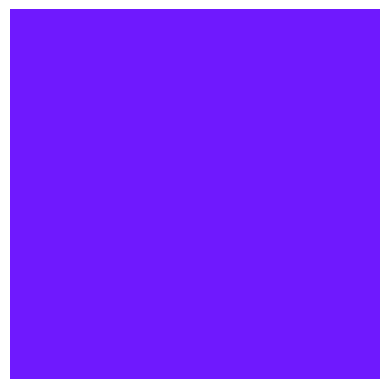

In [ ]:
# Gerar a paleta 'rainbow' com 30 cores
palette = sns.color_palette("rainbow",30)

# A primeira cor da paleta (índice 0)
first_color = palette[0]

# Plotar a cor em um gráfico
plt.imshow([[first_color]])
plt.axis('off')  # Desativar os eixos para visualizar apenas a cor
plt.show()

In [ ]:
import numpy as np
import pandas as pd

def load_media_data(axis=None, bs_ue_list=None, simulation_list=None, raw_data=None):
    data = []
    for bs in bs_ue_list:
        for sim in simulation_list:
            media = np.mean(raw_data[bs][sim][axis])
            data.append({'bs': bs, f'media por simulação (axis={axis})': media})

    df = pd.DataFrame(data)

    return df

In [ ]:
config = load_config('config.yml')

raw_data = load_raw_data (config['general']['file'], config['general']['type_link'])

simulation_list = create_list(config['general']['s_min'], config['general']['s_max'], config['general']['s_step'])
bs_ue_list = create_list(config['general']['bs_ue_min'], config['general']['bs_ue_max'], config['general']['bs_ue_step'])

1) The raw data from the 08_08_2024-02_18_27.pkl has been loaded!


In [ ]:
df = load_media_data (config['graph']['x_var'], bs_ue_list, simulation_list, raw_data)

df['bs'] += 1

<ipython-input-48-f9372116a736>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


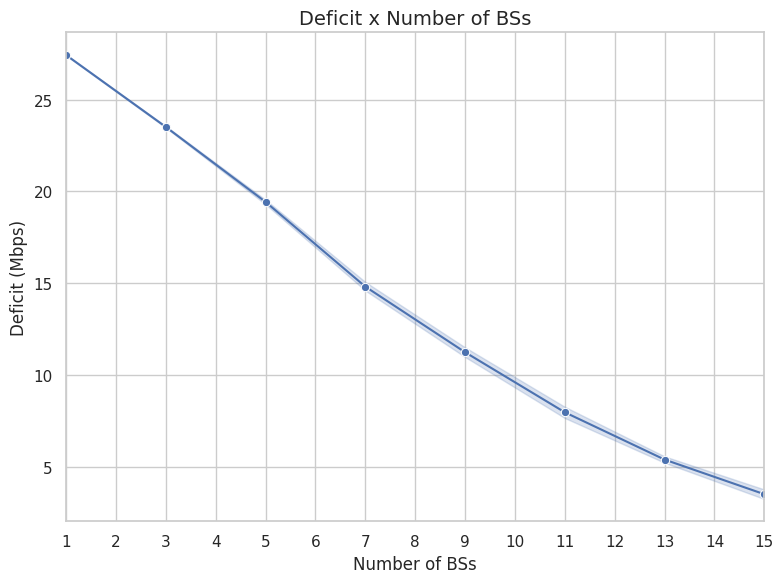

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

axis = config['graph']['x_var']
plt.figure(figsize=(8, 6))

# Cria o gráfico
sns.lineplot(
    data=df,
    x='bs',  # Número de BS no eixo x
    y=f'media por simulação (axis={axis})',
    marker='o',
    palette='viridis',  # Paleta de cores
)

# Títulos e rótulos
plt.title("Deficit x Number of BSs", fontsize=14)
plt.xlabel("Number of BSs", fontsize=12)
plt.ylabel("Deficit (Mbps)", fontsize=12)
plt.xlim(1, 15)
plt.xticks(ticks=list(range(1, 16)), labels=list(range(1, 16)))
plt.tight_layout()

plt.savefig("grafico_deficit.png", dpi=600)

# Exibe o gráfico
plt.show()